<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>




```
# This is formatted as code
```

### Full Name: Alireza Fayyazi
### Student ID: 401208464

# Import necessary libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [16]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

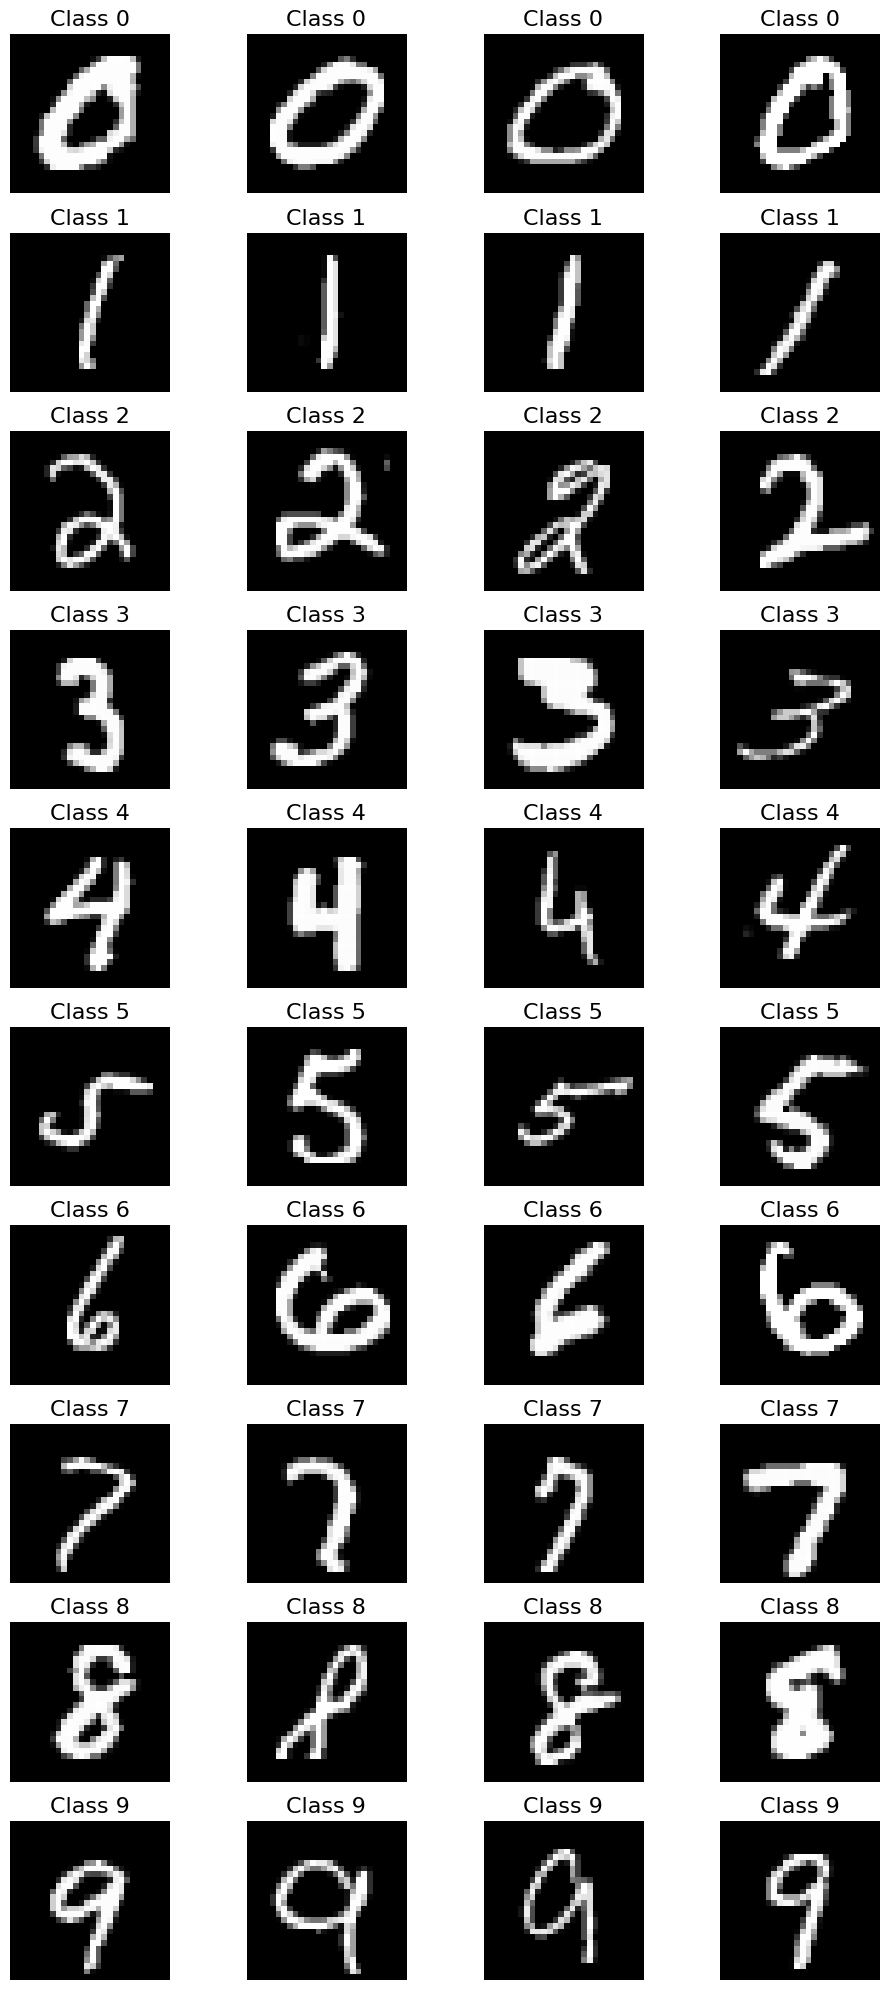

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [17]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU()
                )
        self.fc_mu = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,input_dim),
            nn.Sigmoid()
            # TODO: Add layers for the decoder
        )

    def reparametrize(self, mu, logvar):
        #eps = torch.randn_like(logvar)
        eps = torch.randn_like(logvar)
        #z = mu + torch.exp(0.5 * logvar) * eps
        z = mu + logvar * eps
        return z

    def forward(self, x):
        x = x.view(x.size(0),-1)
        out = self.encoder(x)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        z = self.reparametrize(mu,logvar)
        reconstructed = self.decoder(z)
        return reconstructed,mu,logvar

In [18]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = - 0.5 * torch.sum(-mu.pow(2) - logvar.exp() + 1 + logvar )

    return reconstruction_loss + kl_divergence

In [19]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            optimizer.zero_grad()
            recon,mu,logvar = model(data)
            # TODO: Flatten the data and recon tensors
            data = data.view(data.size(0),-1)
            recon = recon.view(recon.size(0),-1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon,data,mu,logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss/len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    torch.save(model.state_dict(), "best_vae_mlp_model.pth")
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 11498.090139946195
Sample Images:


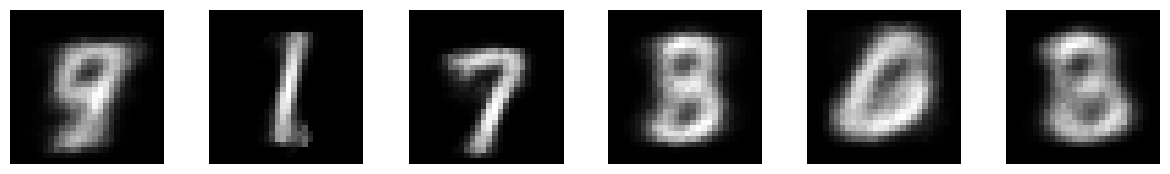


##################################################
VAE-MLP Epoch [2/10], Loss: 10219.230818563432
Sample Images:


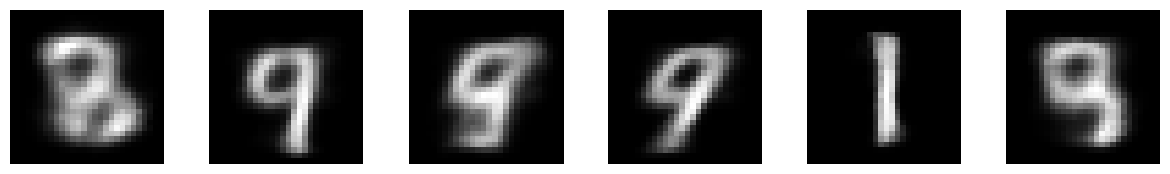


##################################################
VAE-MLP Epoch [3/10], Loss: 9974.04178032133
Sample Images:


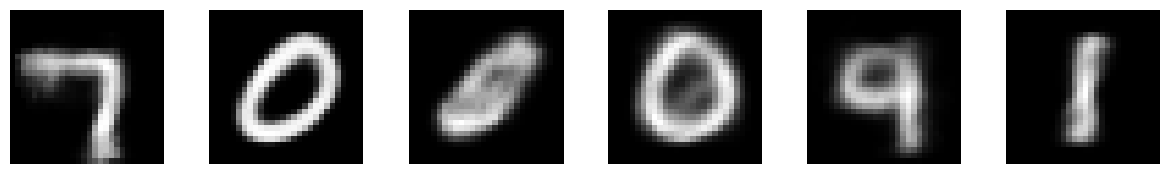


##################################################
VAE-MLP Epoch [4/10], Loss: 9820.888118003732
Sample Images:


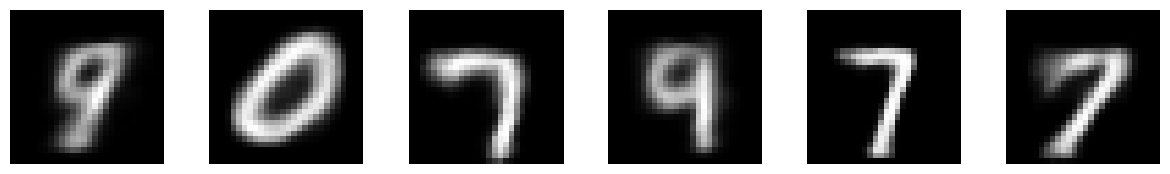


##################################################
VAE-MLP Epoch [5/10], Loss: 9726.726192905451
Sample Images:


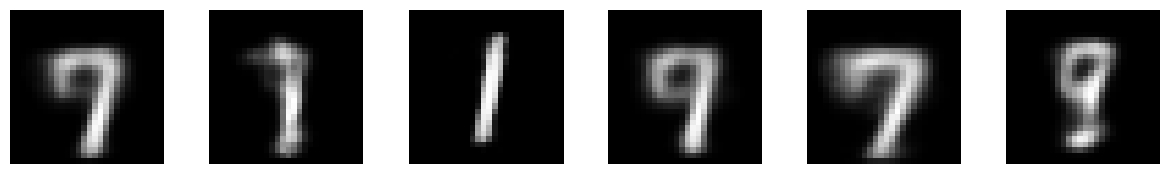


##################################################
VAE-MLP Epoch [6/10], Loss: 9646.549758358042
Sample Images:


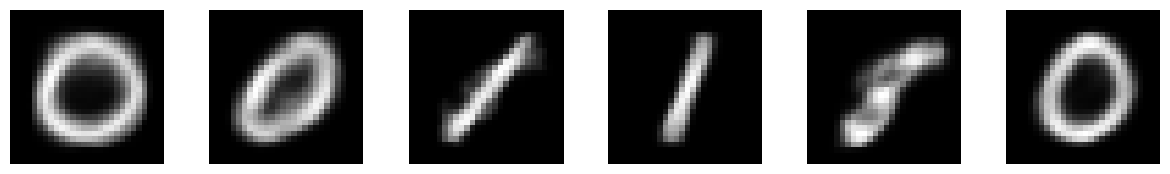


##################################################
VAE-MLP Epoch [7/10], Loss: 9597.709721481877
Sample Images:


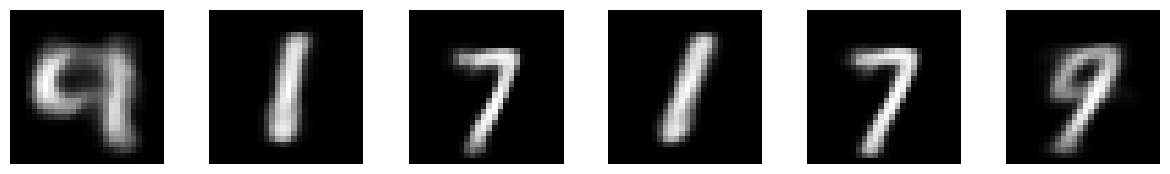


##################################################
VAE-MLP Epoch [8/10], Loss: 9545.716209167611
Sample Images:


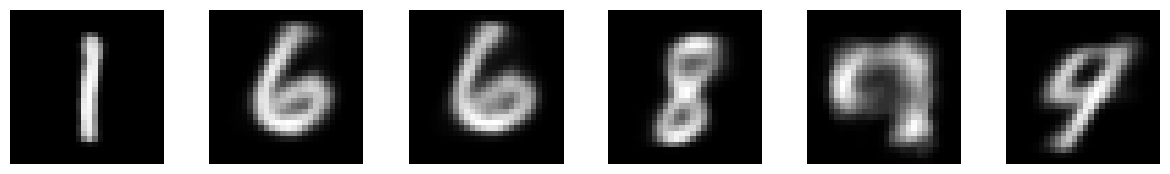


##################################################
VAE-MLP Epoch [9/10], Loss: 9539.841843204458
Sample Images:


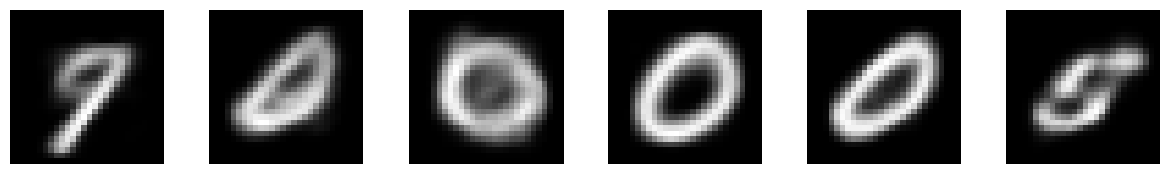


##################################################
VAE-MLP Epoch [10/10], Loss: 9505.789971910814
Sample Images:


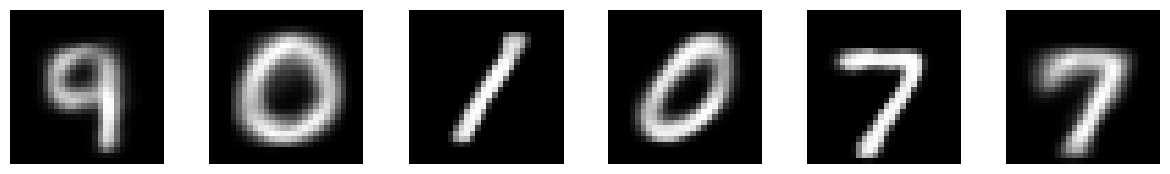

Best model saved as 'best_vae_mlp_model.pth'


In [ ]:
# Train VAE-MLP
vae_mlp = VAE_MLP(28*28,300,2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [74]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_classes + input_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU()
            # TODO: Add layers for the encoder
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(num_classes + latent_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,input_dim),
            nn.Sigmoid()
            # TODO: Add layers for the decoder
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        eps = torch.randn_like(logvar)
        z = mu + logvar * eps
        return z


    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat((x, y), dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)
        input_decoder = torch.cat((z, y), dim=1)
        reconstructed = self.decoder(input_decoder)

        return reconstructed, mu, logvar, class_logits


In [75]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0),-1)
    recon = recon.view(recon.size(0),-1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = - 0.5 * torch.sum(-mu.pow(2) - logvar.exp() + 1 + logvar )

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='mean')

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss
    return total_loss


In [76]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon,mu,logvar,class_logits = model(data,labels_one_hot)

            # TODO: Backpropagation and optimization step
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss/len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    torch.save(model.state_dict(), "best_cvae_mlp_model.pth")
    print("Best model saved as 'best_cvae_mlp_model.pth'")




##################################################
CVAE-MLP Epoch [1/10], Loss: 10823.290500795409
Sample Images:


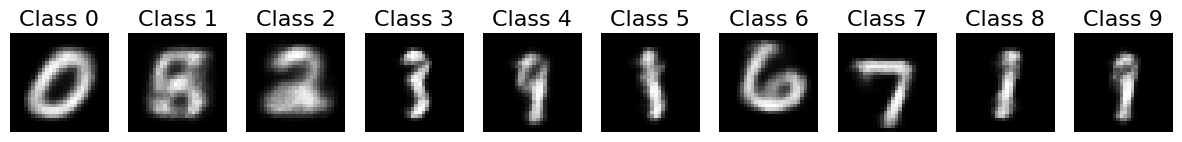


##################################################
CVAE-MLP Epoch [2/10], Loss: 9144.134385098781
Sample Images:


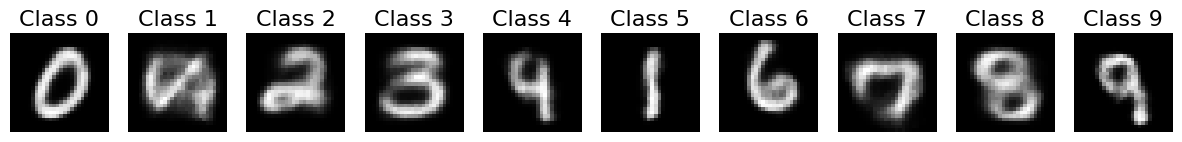


##################################################
CVAE-MLP Epoch [3/10], Loss: 8815.812168666294
Sample Images:


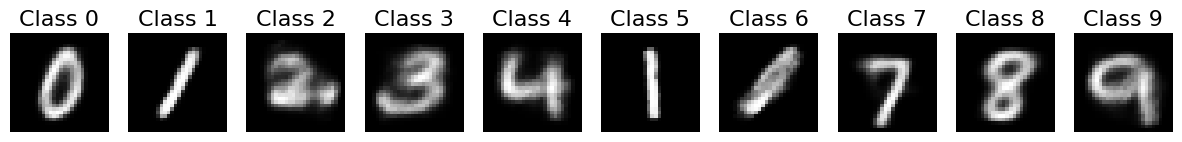


##################################################
CVAE-MLP Epoch [4/10], Loss: 8687.01942713886
Sample Images:


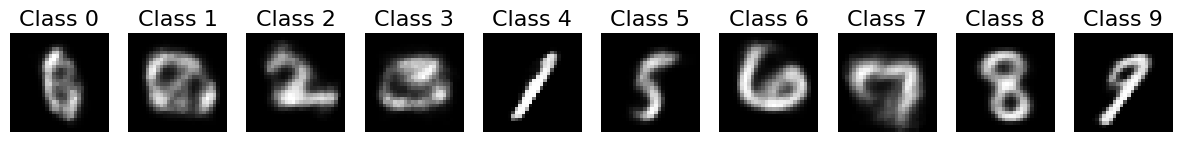


##################################################
CVAE-MLP Epoch [5/10], Loss: 8596.651711795375
Sample Images:


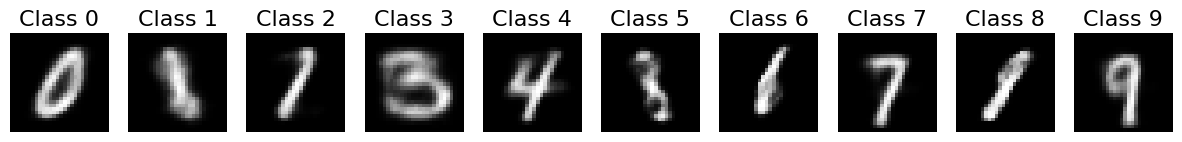


##################################################
CVAE-MLP Epoch [6/10], Loss: 8543.063038254597
Sample Images:


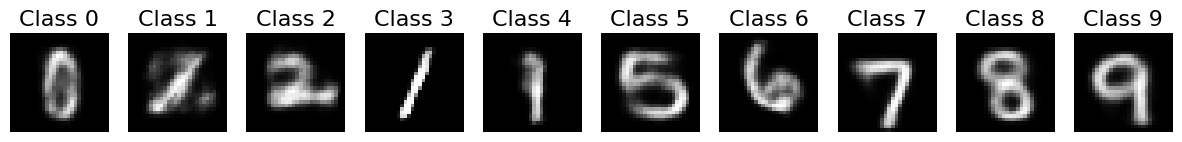


##################################################
CVAE-MLP Epoch [7/10], Loss: 8488.817554595882
Sample Images:


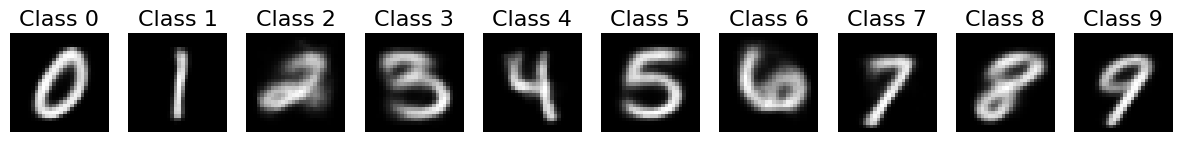


##################################################
CVAE-MLP Epoch [8/10], Loss: 8449.326077654418
Sample Images:


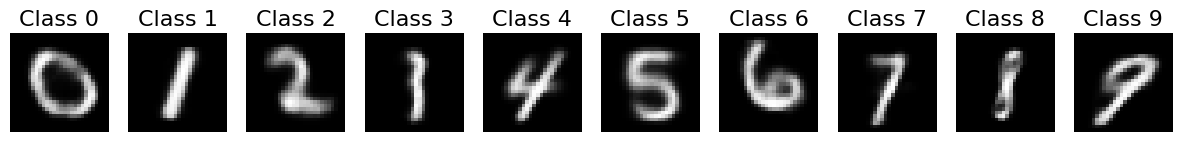


##################################################
CVAE-MLP Epoch [9/10], Loss: 8424.245737689898
Sample Images:


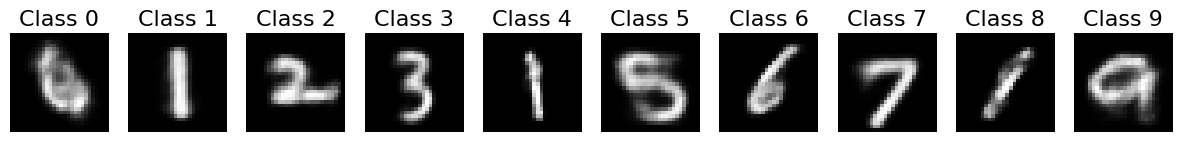


##################################################
CVAE-MLP Epoch [10/10], Loss: 8394.867546162879
Sample Images:


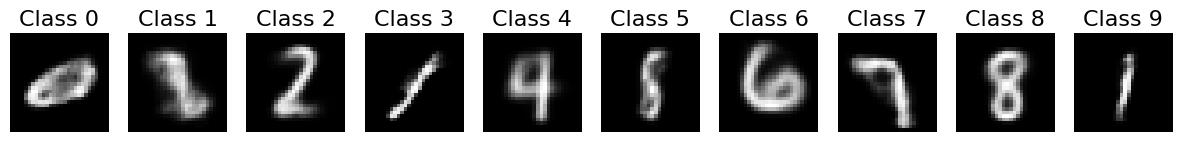

Best model saved as 'best_cvae_mlp_model.pth'


In [77]:
cvae_mlp = CVAE_MLP(28*28,300,2,10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


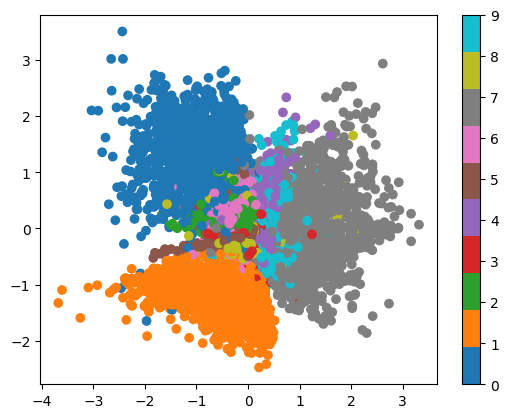

In [67]:
for batch_idx, (data, tag) in enumerate(train_loader):
    data = data.view(data.size(0),-1)
    out = vae_mlp.encoder(data)
    out = vae_mlp.fc_mu(out)
    out = out.detach().numpy()
    plt.scatter(out[:, 0], out[:, 1], c=tag, cmap='tab10')
    if batch_idx > 256:
      plt.colorbar()
      break



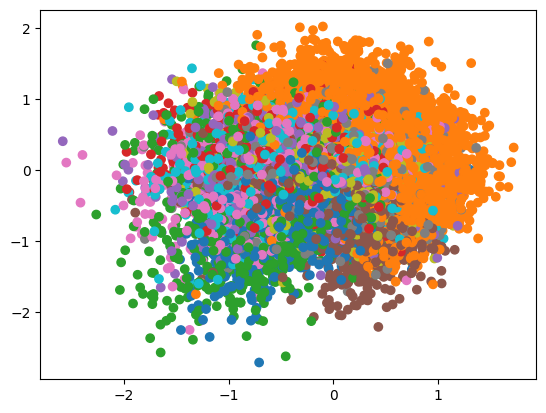

In [78]:
for batch_idx, (data, tag) in enumerate(train_loader):
    data = data.view(data.size(0),-1)
    one_hot = F.one_hot(tag, num_classes=10)
    one_hot = one_hot.view(tag.size(0), -1)
    data = torch.cat((data,one_hot), dim=1)
    out =cvae_mlp.encoder(data)
    out = cvae_mlp.fc_mu(out)
    out = out.detach().numpy()
    plt.scatter(out[:, 0], out[:, 1], c=tag, cmap='tab10')
    if batch_idx > 1024:
      plt.colorbar()
      break

